In [17]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, time, timedelta
import warnings
import os
from tqdm import tqdm

warnings.filterwarnings('ignore')  # 过滤不必要的warnings
plt.rcParams["font.sans-serif"] = ['Hiragino Sans GB']  # set font
plt.rcParams["axes.unicode_minus"] = False  # solve "-"

In [18]:
''' 基本参数 '''
list_color = ['#044E7E', '#FF3333', '#367198', '#FF8080', '#81A6BE', '#FFB2B2', '#000000', '#999999','#666633','#996633']

begin_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  

index_code = '000300.SH' # 沪深300代码
option_name = '沪深300指数期权'

file_path = ('/Users/15022/Desktop/算法交易/作业/VIX指数因子/VIX指数因子')

In [19]:
''' 指数期权数据 '''
data_1 = pd.read_pickle(f'{file_path}/ChinaOptionDescription.pkl')
data_2 = pd.read_pickle(f'{file_path}/ChinaOptionEODPrices2.pkl')

''' 无风险利率数据 '''
df_bond_rate = pd.read_excel(f'{file_path}/df_bond_rate.xlsx')
df_bond_index = pd.read_excel(f'{file_path}/df_bond_index_pct.xlsx')

''' 指数数据 '''
df_index = pd.read_excel(f'{file_path}/df_000300.SH_data.xlsx')

df_1 = pd.DataFrame(data_1)
df_2 = pd.DataFrame(data_2)

In [20]:
''' 期权数据整理 '''
df_1.rename(columns = {
    'S_INFO_WINDCODE':'月合约wind代码', 'S_INFO_NAME':'月合约全称',
    'S_INFO_SCCODE':'期权wind代码', 'S_INFO_CALLPUT':'月合约类别',
    'S_INFO_MATURITYDATE':'到期日', 'S_INFO_STRIKEPRICE':'期权行权价'
    },inplace=True)

df_1 = df_1.loc[:, ['月合约wind代码', '月合约全称', '期权wind代码', '月合约类别', '到期日', '期权行权价']]
df_1['到期日'] = pd.to_datetime(df_1['到期日'], format='%Y%m%d')

# 修改月合约类别 ‘708001000’修改为‘call', ‘708002000’修改为‘put'
df_1['月合约类别'].replace({708001000 : 'call', 708002000 : 'put'}, inplace=True)

df_2.rename(columns = {
    'S_INFO_WINDCODE':'wind代码', 'TRADE_DT':'交易日期', 'S_DQ_CLOSE':'收盘价',
    'S_DQ_VOLUME':'成交量'
    },inplace=True)

df_2 = df_2.loc[:, ['wind代码', '交易日期', '收盘价', '成交量']]
df_2['交易日期'] = pd.to_datetime(df_2['交易日期'], format='%Y%m%d')
df_2 = df_2.sort_values(by='交易日期')

df_merged = pd.merge(df_2, df_1, left_on='wind代码', right_on='月合约wind代码', how='inner')
df_merged.dropna(inplace=True)

In [21]:
''' 筛选指定股指期权数据 '''
df_merged = df_merged[df_merged['月合约全称'].str.contains(option_name, na=False)]

# 根据月合约类比列分离看涨(call)和看跌(put)期权
df_calls = df_merged[df_merged['月合约类别'] == 'call']
df_puts = df_merged[df_merged['月合约类别'] == 'put']

# 按顺序排序
df_sorted = pd.merge(df_calls, df_puts, on=['交易日期', '到期日', '期权行权价', ], suffixes=('_call', '_put'))
df_sorted = df_sorted.sort_values(by=['交易日期', '到期日', '期权行权价'])

# ------------------------------ 加入无风险利率数据 ------------------------------
df_bond_rate['日期'] = pd.to_datetime(df_bond_rate['日期'])
df_sorted = pd.merge(df_sorted, df_bond_rate, left_on='交易日期', right_on='日期', how='left')

# ------------------------------ 加入指数数据 ------------------------------
df_index['日期'] = pd.to_datetime(df_index['日期'])
df_sorted = pd.merge(df_sorted, df_index, left_on='交易日期', right_on='日期', how='left')

# ------------------------------ 加入中债指数数据 ------------------------------
df_bond_index['日期'] = pd.to_datetime(df_bond_index['日期'])
df_sorted = pd.merge(df_sorted, df_bond_index, left_on='交易日期', right_on='日期', how='left')

df_sorted.drop(columns = ['日期_x', 'Unnamed: 0_x', '日期_y', 'Unnamed: 0_y', '日期', 'Unnamed: 0'], inplace=True)
df_sorted.head()


,wind代码_call,交易日期,收盘价_call,成交量_call,月合约wind代码_call,月合约全称_call,期权wind代码_call,月合约类别_call,到期日,期权行权价,wind代码_put,收盘价_put,成交量_put,月合约wind代码_put,月合约全称_put,期权wind代码_put,月合约类别_put,R,index_close,bond_index_pct
0,IO2002-C-3600.CFE,2019-12-23,399.2000,308.0000,IO2002-C-3600.CFE,沪深300指数期权2002认购3600,IO.CFE,call,2020-02-21,3600.0000,IO2002-P-3600.CFE,4.6000,1006.0000,IO2002-P-3600.CFE,沪深300指数期权2002认沽3600,IO.CFE,put,0.031661,3967.0962,0.000988
1,IO2002-C-3650.CFE,2019-12-23,360.0000,237.0000,IO2002-C-3650.CFE,沪深300指数期权2002认购3650,IO.CFE,call,2020-02-21,3650.0000,IO2002-P-3650.CFE,7.8000,805.0000,IO2002-P-3650.CFE,沪深300指数期权2002认沽3650,IO.CFE,put,0.031661,3967.0962,0.000988
2,IO2002-C-3700.CFE,2019-12-23,331.8000,278.0000,IO2002-C-3700.CFE,沪深300指数期权2002认购3700,IO.CFE,call,2020-02-21,3700.0000,IO2002-P-3700.CFE,12.6000,1159.0000,IO2002-P-3700.CFE,沪深300指数期权2002认沽3700,IO.CFE,put,0.031661,3967.0962,0.000988
3,IO2002-C-3750.CFE,2019-12-23,260.4000,146.0000,IO2002-C-3750.CFE,沪深300指数期权2002认购3750,IO.CFE,call,2020-02-21,3750.0000,IO2002-P-3750.CFE,20.0000,528.0000,IO2002-P-3750.CFE,沪深300指数期权2002认沽3750,IO.CFE,put,0.031661,3967.0962,0.000988
4,IO2002-C-3800.CFE,2019-12-23,223.6000,134.0000,IO2002-C-3800.CFE,沪深300指数期权2002认购3800,IO.CFE,call,2020-02-21,3800.0000,IO2002-P-3800.CFE,29.6000,704.0000,IO2002-P-3800.CFE,沪深300指数期权2002认沽3800,IO.CFE,put,0.031661,3967.0962,0.000988


In [22]:
''' 筛选近月合约和近次月合约数据 '''
# 计算剩余到期天数
df_sorted['剩余到期天数'] = (df_sorted['到期日'] - df_sorted['交易日期']).dt.days

# 筛选剩余到期天数超过7天的合约
df_sorted = df_sorted[df_sorted['剩余到期天数'] > 7]

# 获取近月合约的数据
df_near_month_contract = df_sorted.groupby('交易日期').apply(lambda x: x[x['剩余到期天数'] == x['剩余到期天数'].min()]).reset_index(level=0, drop=True)

# 排除已选择的近月合约数据
remaining_data = df_sorted[~df_sorted.index.isin(df_near_month_contract.index)]

# 获取次近月合约的数据
df_next_near_month_contract = remaining_data.groupby('交易日期').apply(lambda x: x[x['剩余到期天数'] == x['剩余到期天数'].min()]).reset_index(level=0, drop=True)

df_near_month_contract.head()

,wind代码_call,交易日期,收盘价_call,成交量_call,月合约wind代码_call,月合约全称_call,期权wind代码_call,月合约类别_call,到期日,期权行权价,...,收盘价_put,成交量_put,月合约wind代码_put,月合约全称_put,期权wind代码_put,月合约类别_put,R,index_close,bond_index_pct,剩余到期天数
0,IO2002-C-3600.CFE,2019-12-23,399.2000,308.0000,IO2002-C-3600.CFE,沪深300指数期权2002认购3600,IO.CFE,call,2020-02-21,3600.0000,...,4.6000,1006.0000,IO2002-P-3600.CFE,沪深300指数期权2002认沽3600,IO.CFE,put,0.031661,3967.0962,0.000988,60
1,IO2002-C-3650.CFE,2019-12-23,360.0000,237.0000,IO2002-C-3650.CFE,沪深300指数期权2002认购3650,IO.CFE,call,2020-02-21,3650.0000,...,7.8000,805.0000,IO2002-P-3650.CFE,沪深300指数期权2002认沽3650,IO.CFE,put,0.031661,3967.0962,0.000988,60
2,IO2002-C-3700.CFE,2019-12-23,331.8000,278.0000,IO2002-C-3700.CFE,沪深300指数期权2002认购3700,IO.CFE,call,2020-02-21,3700.0000,...,12.6000,1159.0000,IO2002-P-3700.CFE,沪深300指数期权2002认沽3700,IO.CFE,put,0.031661,3967.0962,0.000988,60
3,IO2002-C-3750.CFE,2019-12-23,260.4000,146.0000,IO2002-C-3750.CFE,沪深300指数期权2002认购3750,IO.CFE,call,2020-02-21,3750.0000,...,20.0000,528.0000,IO2002-P-3750.CFE,沪深300指数期权2002认沽3750,IO.CFE,put,0.031661,3967.0962,0.000988,60
4,IO2002-C-3800.CFE,2019-12-23,223.6000,134.0000,IO2002-C-3800.CFE,沪深300指数期权2002认购3800,IO.CFE,call,2020-02-21,3800.0000,...,29.6000,704.0000,IO2002-P-3800.CFE,沪深300指数期权2002认沽3800,IO.CFE,put,0.031661,3967.0962,0.000988,60


In [23]:
''' 处理合约数据得到对应的VIX '''
def get_VIX(df):
    '''
    获取近月合约或次近月合约的VIX
    :param df: 近月合约df 或者 次近月合约df
    :return: 对应的VIX的df
    '''
    # ----- 计算S列 -----
    # 计算收盘价的差值绝对值
    df['价格差'] = abs(df['收盘价_call'] - df['收盘价_put'])
    # 对每个交易日期下的差值进行排序，取差值最小的行
    df['S'] = df.sort_values(by=['交易日期', '价格差']).groupby('交易日期')['期权行权价'].transform('first')
    
    # ----- 计算T列 -----
    df['T'] = df['剩余到期天数'] / 365

    # ----- 计算F列 -----
    # 转换为 float 类型，以避免类型冲突
    df['收盘价_call'] = df['收盘价_call'].astype(float)
    df['收盘价_put'] = df['收盘价_put'].astype(float)
    df['R'] = df['R'].astype(float)
    df['T'] = df['T'].astype(float)
    df['S'] = df['S'].astype(float)
    df['期权行权价'] = df['期权行权价'].astype(float)
    df['成交量_call'] = df['成交量_call'].astype(float)
    df['成交量_put'] = df['成交量_put'].astype(float)
    
    # 筛选出期权行权价和S相同的数据
    selected_rows = df[df['S'] == df['期权行权价']]
    selected_rows['F'] = selected_rows['S'] + (selected_rows['收盘价_call'] - selected_rows['收盘价_put']) * np.exp(selected_rows['R'] * selected_rows['T'])

    df = pd.merge(df, selected_rows[['交易日期', 'F']], on=['交易日期'], how='left')
    
    # ----- 计算K0列 -----
    # 首先，定义一个函数，对于给定的交易日期子数据集，找到符合条件的K0
    def get_K0(sub_df):
        # 在子数据集中找到小于F且最接近F的期权行权价
        eligible_strikes = sub_df[sub_df['期权行权价'] < sub_df['F']]['期权行权价']
        if eligible_strikes.empty:
            # 如果没有小于F的期权行权价，则选择最小的期权行权价
            return sub_df['期权行权价'].min()
        else:
            # 如果有小于F的期权行权价，则选择最接近F的（最大的一个）
            return eligible_strikes.max()

    # 应用这个函数到每个日期的分组上，并创建一个包含所有日期的K0值的字典
    K0_values = df.groupby('交易日期').apply(get_K0).to_dict()
    # 使用日期将K0值映射回原始数据框中的每行
    df['K0'] = df['交易日期'].map(K0_values)
    
    # ----- 计算Ki和delta_Ki列 -----
    def calculate_delta_Ki_for_date(group):
        # 对期权行权价进行排序
        sorted_strikes = group['期权行权价']
        group['Ki'] = sorted_strikes
        # 计算delta_Ki
        deltas = [sorted_strikes.iloc[i + 1] - sorted_strikes.iloc[i] if i == 0
                  else sorted_strikes.iloc[i] - sorted_strikes.iloc[i - 1] if i == len(sorted_strikes) - 1
                  else (sorted_strikes.iloc[i + 1] - sorted_strikes.iloc[i - 1]) / 2
                  for i in range(len(sorted_strikes))]
        group['delta_Ki'] = deltas
        return group

    # 应用分组计算，'交易日期'为分组依据
    df = df.groupby('交易日期', group_keys=False).apply(calculate_delta_Ki_for_date)

    # ----- 计算P(Ki)列 -----
    df['P(Ki)'] = df.apply(
        lambda row: row['收盘价_put'] if row['Ki'] < row['K0'] else
                    (row['收盘价_put'] + row['收盘价_call']) / 2 if row['Ki'] == row['K0'] else
                    row['收盘价_call'],
        axis=1
    )
    
    # ----- 计算Vi列 -----
    df['Vi'] = df.apply(
        lambda row: row['成交量_put'] if row['Ki'] < row['K0'] else
                    (row['成交量_put'] + row['成交量_call']) / 2 if row['Ki'] == row['K0'] else
                    row['成交量_call'],
        axis=1
    )

    # ----- 计算VIX公式中的累加项 -----
    def calculate_first_term_sum(row):
        '''
        计算等待累加项
        '''
        delta_Ki = row['delta_Ki']
        Ki = row['Ki']
        P_Ki = row['P(Ki)']
        R = row['R']
        T = row['T']
        first_term_sum = (delta_Ki / Ki ** 2) * np.exp(R * T) * P_Ki

        return first_term_sum


    df['first_term_sum'] = df.apply(calculate_first_term_sum, axis=1)
    
    # ----- 计算VIX成交量公式中的成交量总和 -----
    def calculate_first_term_sum_Vi(row):
        '''
        计算等待累加项
        '''
        delta_Ki = row['delta_Ki']
        Ki = row['Ki']
        P_Ki = row['P(Ki)']
        R = row['R']
        T = row['T']
        Vi = row['Vi']
        first_term_sum_Vi = Vi * P_Ki * (delta_Ki / Ki ** 2) * np.exp(R * T) 

        return first_term_sum_Vi

    df['first_term_sum'] = df.apply(calculate_first_term_sum, axis=1)
    df['first_term_sum_Vi'] = df.apply(calculate_first_term_sum_Vi, axis=1)
    
    # ----- 计算N列 -----
    df['N'] = df.groupby('交易日期')['交易日期'].transform('size')
    
    # ----- 计算Vi_sum列 -----
    df['Vi_sum'] = df.groupby('交易日期')['Vi'].transform('sum')
    
    ''' 计算GVIX所需数据 '''
    # ----- 计算S0和K0列 -----
    def calculate_S0_G(sub_df):
        # 在每个交易日期找到'期权行权价'最接近'etf_close'的行
        closest_row = sub_df.iloc[(sub_df['期权行权价'] - sub_df['index_close']).abs().argsort()[:1]]
        S0 = closest_row['收盘价_call'].values[0] - closest_row['收盘价_put'].values[0] + closest_row['期权行权价'].values[0] * np.exp(-closest_row['R'].values[0] * closest_row['T'].values[0])
        return S0
    
    # 应用这个函数到每个日期的分组上，并创建一个包含所有日期的S0值的字典
    S0_values = df.groupby('交易日期').apply(calculate_S0_G).to_dict()
    
    # 使用日期将S0值映射回原始数据框中的每行
    df['S0_G'] = df['交易日期'].map(S0_values)
    
    df['F0_G'] = df['S0_G'] * np.exp(df['R'] * df['T'])
    
    def get_K0_G(sub_df):
        # 在子数据集中找到小于F且最接近F的期权行权价
        eligible_strikes = sub_df[sub_df['期权行权价'] < sub_df['F0_G']]
        if eligible_strikes.empty:
            # 如果没有小于F的期权行权价，则选择最小的期权行权价
            return sub_df['期权行权价'].min()
        else:
            # 如果有小于F的期权行权价，则选择最接近F的（最大的一个）
            return eligible_strikes.max()

    # 应用这个函数到每个日期的分组上，并创建一个包含所有日期的K0值的字典
    K0_G_values = df.groupby('交易日期').apply(get_K0).to_dict()
    # 使用日期将K0值映射回原始数据框中的每行
    df['K0_G'] = df['交易日期'].map(K0_G_values)
    
    # ----- 计算GVIX中的mu的求和项 -----
    def calculate_GVIX_mu_sum(row):
        '''
        计算等待累加项
        '''
        delta_Ki = row['delta_Ki']
        Ki = row['Ki']
        Q_Ki = row['P(Ki)']
        GVIX_mu_sum = Q_Ki * delta_Ki / (Ki ** 2)
        
        return GVIX_mu_sum

    df['GVIX_mu_sum'] = df.apply(calculate_GVIX_mu_sum, axis=1)
    
    # ----- 计算GVIX中的mu的求和项 -----
    def calculate_GVIX_V_sum(row):
        '''
        计算等待累加项
        '''
        S0 = row['S0_G']
        delta_Ki = row['delta_Ki']
        Ki = row['Ki']
        Q_Ki = row['P(Ki)']
        GVIX_V_sum = (1+ np.log(S0 / Ki)) * Q_Ki * delta_Ki / (Ki ** 2)
        
        return GVIX_V_sum

    df['GVIX_V_sum'] = df.apply(calculate_GVIX_V_sum, axis=1)
    
    # ----- 计算VIX指数，VIX_成交量指数 -----
    # 交易日期下不变的项
    R_per_date = df.groupby('交易日期')['R'].first()
    bond_index_pct_per_date = df.groupby('交易日期')['bond_index_pct'].first()
    T_per_date = df.groupby('交易日期')['T'].first()
    F_per_date = df.groupby('交易日期')['F'].first()
    K0_per_date = df.groupby('交易日期')['K0'].first()
    N_per_date = df.groupby('交易日期')['N'].first()
    Vi_sum_per_date = df.groupby('交易日期')['Vi_sum'].first()
    S0_G_sum_per_date = df.groupby('交易日期')['S0_G'].first()
    F0_G_sum_per_date = df.groupby('交易日期')['F0_G'].first()
    K0_G_sum_per_date = df.groupby('交易日期')['K0_G'].first()
    index_close = df.groupby('交易日期')['index_close'].first()
    
    # 交易日期下需要加总的项
    df_VIX = df.groupby('交易日期')['first_term_sum'].sum().reset_index()
    df_VIX_vol = df.groupby('交易日期')['first_term_sum_Vi'].sum().reset_index()
    df_GVIX_mu = df.groupby('交易日期')['GVIX_mu_sum'].sum().reset_index()
    df_GVIX_V = df.groupby('交易日期')['GVIX_V_sum'].sum().reset_index()
    
    # 合并不变项
    df_VIX = df_VIX.merge(R_per_date, on='交易日期', how='left')
    df_VIX = df_VIX.merge(bond_index_pct_per_date, on='交易日期', how='left') 
    df_VIX = df_VIX.merge(T_per_date, on='交易日期', how='left')
    df_VIX = df_VIX.merge(F_per_date, on='交易日期', how='left')
    df_VIX = df_VIX.merge(K0_per_date, on='交易日期', how='left')
    df_VIX = df_VIX.merge(N_per_date, on='交易日期', how='left')
    df_VIX = df_VIX.merge(Vi_sum_per_date, on='交易日期', how='left')
    df_VIX = df_VIX.merge(S0_G_sum_per_date, on='交易日期', how='left')    
    df_VIX = df_VIX.merge(F0_G_sum_per_date, on='交易日期', how='left')
    df_VIX = df_VIX.merge(K0_G_sum_per_date, on='交易日期', how='left')  
    df_VIX = df_VIX.merge(index_close, on='交易日期', how='left') 
    
    # 合并加总项
    df_VIX = df_VIX.merge(df_VIX_vol, on='交易日期', how='left')
    df_VIX = df_VIX.merge(df_GVIX_mu, on='交易日期', how='left')
    df_VIX = df_VIX.merge(df_GVIX_V, on='交易日期', how='left')

    
    # VIX计算公式
    df_VIX['VIX'] = 2 / df_VIX['T'] * df_VIX['first_term_sum'] - 1 / df_VIX['T'] * (
                (df_VIX['F'] / df_VIX['K0'] - 1) ** 2)
    
    # VIX_vol计算公式
    df_VIX['VIX_vol'] = 2 * df_VIX['N'] / (df_VIX['T'] * df_VIX['Vi_sum']) * df_VIX['first_term_sum_Vi'] - 1 / df_VIX['T'] * (
                (df_VIX['F'] / df_VIX['K0'] - 1) ** 2)

    # GVIX计算公式
    df_VIX['mu'] = (np.log(df_VIX['K0_G'] / df_VIX['S0_G']) + (df_VIX['F0_G'] / df_VIX['K0_G'] - 1)) - df_VIX['GVIX_mu_sum'] * np.exp(df_VIX['R'] * df_VIX['T'])
    
    df_VIX['V'] = (np.log(df_VIX['K0_G'] / df_VIX['S0_G']) ** 2) + 2 * (df_VIX['F0_G'] / df_VIX['K0_G'] - 1) * np.log(df_VIX['K0_G'] / df_VIX['S0_G']) + \
                   2 * np.exp(df_VIX['R'] * df_VIX['T']) * df_VIX['GVIX_V_sum']
        
    df_VIX['GVIX'] = (df_VIX['V'] - df_VIX['mu'] ** 2) / df_VIX['T']
    
    return df_VIX

In [24]:
''' 计算VIX指数 '''
df_VIX_near_month_contract = get_VIX(df_near_month_contract)
df_VIX_next_near_month_contract = get_VIX(df_next_near_month_contract)

df_VIX_final = pd.DataFrame()

# 计算VIX指数
df_VIX_final['交易日期'] = df_VIX_near_month_contract['交易日期']
df_VIX_final['index_close'] = df_VIX_near_month_contract['index_close']
df_VIX_final['R'] = df_VIX_near_month_contract['R']
df_VIX_final['bond_index_pct'] = df_VIX_near_month_contract['bond_index_pct']
df_VIX_final['T1'] = df_VIX_near_month_contract['T']
df_VIX_final['T2'] = df_VIX_next_near_month_contract['T']

df_VIX_final['VIX_1'] = df_VIX_near_month_contract['VIX']
df_VIX_final['VIX_2'] = df_VIX_next_near_month_contract['VIX']
df_VIX_final['VIX_1_vol'] = df_VIX_near_month_contract['VIX_vol']
df_VIX_final['VIX_2_vol'] = df_VIX_next_near_month_contract['VIX_vol']
df_VIX_final['GVIX_1'] = df_VIX_near_month_contract['GVIX']
df_VIX_final['GVIX_2'] = df_VIX_next_near_month_contract['GVIX']

df_VIX_final['w'] =  (df_VIX_final['T2'] - 30 / 365) / (df_VIX_final['T2'] - df_VIX_final['T1'])
df_VIX_final['1-w'] = (30 / 365 - df_VIX_final['T1']) / (df_VIX_final['T2'] - df_VIX_final['T1'])

# 计算VIX指数
df_VIX_final['VIX'] = ((df_VIX_final['w'] * df_VIX_final['T1'] * df_VIX_final['VIX_1'] + 
                       df_VIX_final['1-w'] * df_VIX_final['T2'] * df_VIX_final['VIX_2']) * 365 / 30) ** 0.5 * 100

# 计算VIX成交量指数
df_VIX_final['VIX_vol'] = ((df_VIX_final['w'] * df_VIX_final['T1'] * df_VIX_final['VIX_1_vol'] + 
                       df_VIX_final['1-w'] * df_VIX_final['T2'] * df_VIX_final['VIX_2_vol']) * 365 / 30) ** 0.5 * 100

# 计算GVIX指数
df_VIX_final['GVIX'] = ((df_VIX_final['w'] * df_VIX_final['T1'] * df_VIX_final['GVIX_1'] + 
                       df_VIX_final['1-w'] * df_VIX_final['T2'] * df_VIX_final['GVIX_2'] ) * 365 / 30) ** 0.5 * 100

# 计算VIX指数和GVIX指数之间的差值
df_VIX_final['diff'] = df_VIX_final['VIX'] - df_VIX_final['GVIX']
df_VIX_final.set_index('交易日期', inplace=True)
df_VIX_final.dropna(inplace=True)
df_VIX_final.head()

,index_close,R,bond_index_pct,T1,T2,VIX_1,VIX_2,VIX_1_vol,VIX_2_vol,GVIX_1,GVIX_2,w,1-w,VIX,VIX_vol,GVIX,diff
交易日期,,,,,,,,,,,,,,,,,
2019-12-23,3967.0962,0.031661,0.000988,0.164384,0.241096,0.025681,0.027661,0.025226,0.028735,0.025549,0.027527,2.071429,-1.071429,13.949241,11.916278,13.904525,0.044716
2019-12-24,3992.9581,0.031535,0.000606,0.161644,0.238356,0.023505,0.024679,0.033492,0.026824,0.023426,0.024602,2.035714,-1.035714,14.135277,23.133750,14.103664,0.031613
2019-12-25,3990.8671,0.031463,0.000444,0.158904,0.235616,0.022222,0.023969,0.033195,0.025139,0.022149,0.023943,2.000000,-1.000000,13.120963,23.725297,13.040404,0.080559
2019-12-26,4025.9879,0.031137,0.000825,0.156164,0.232877,0.021520,0.023907,0.036450,0.027673,0.021506,0.023948,1.964286,-0.964286,12.247477,24.582604,12.178939,0.068539
2019-12-27,4022.0278,0.031292,0.000104,0.153425,0.230137,0.022609,0.024313,0.037270,0.023303,0.022585,0.024039,1.928571,-0.928571,13.482888,27.126516,13.713080,-0.230191


findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the foll

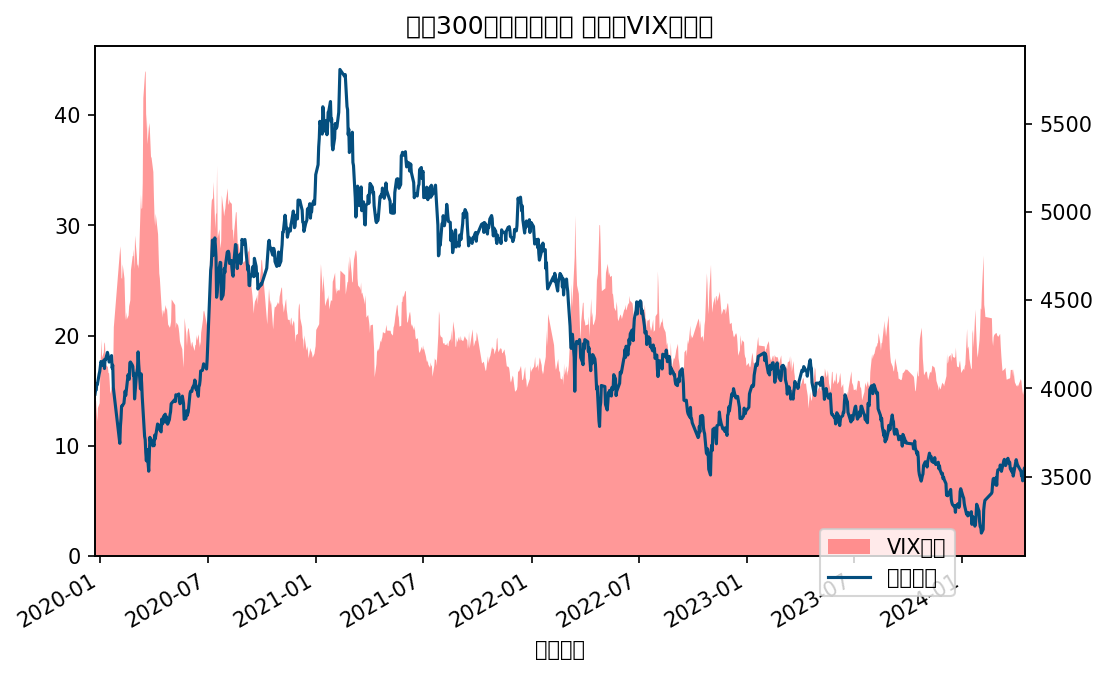

findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the foll

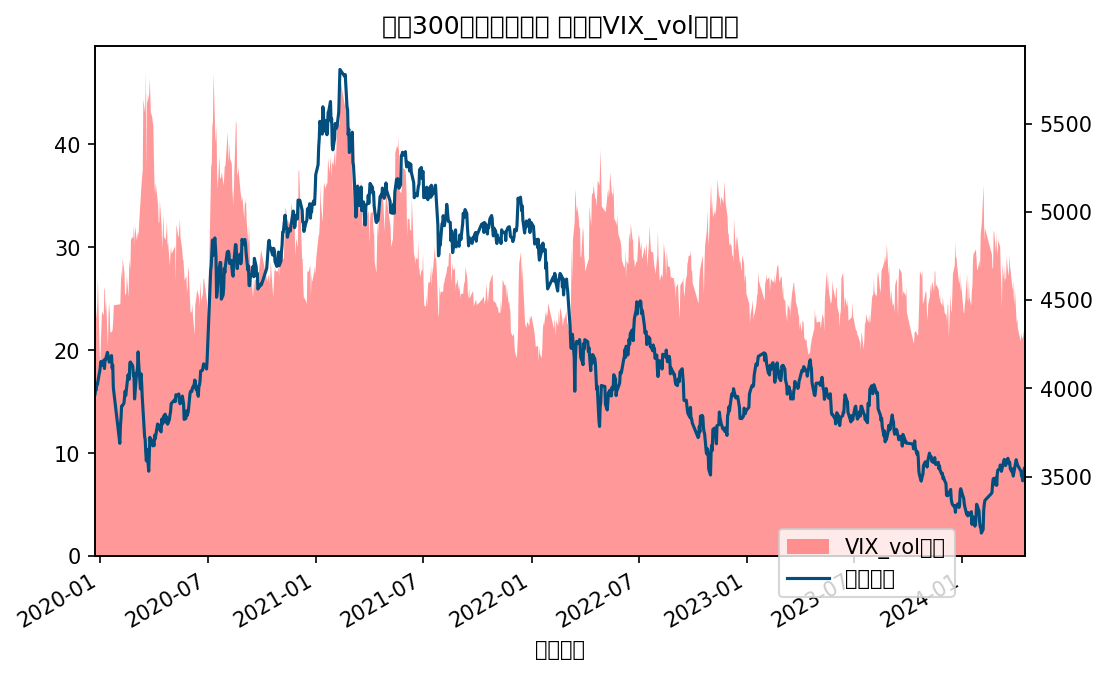

findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the foll

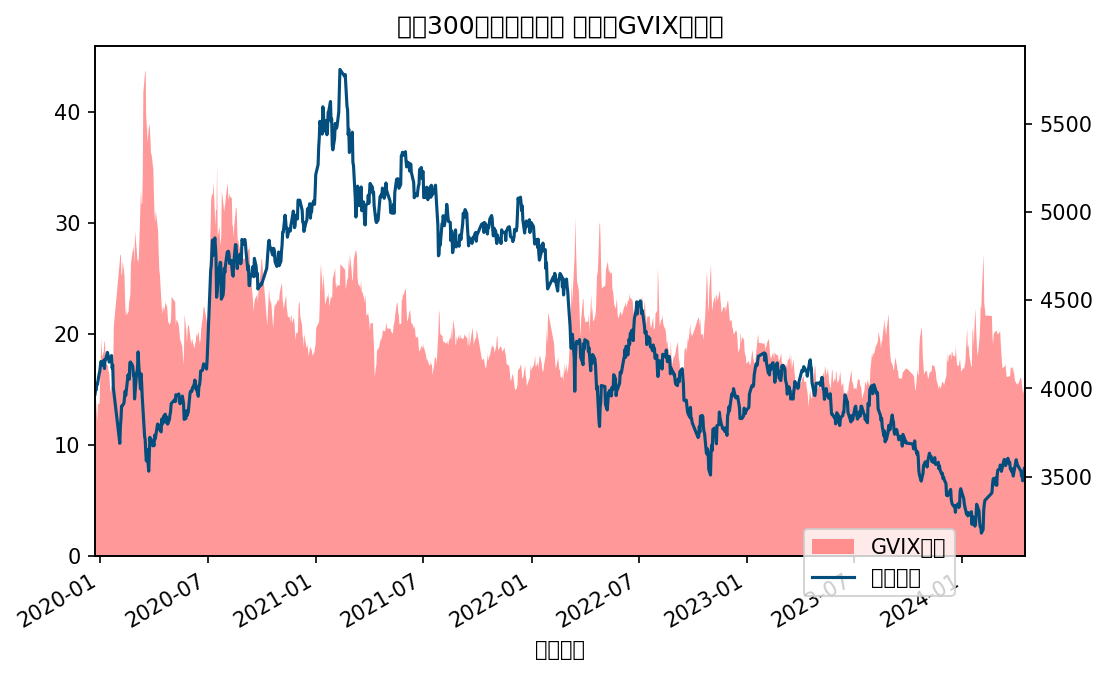

In [25]:
''' 绘制VIX走势图 '''
def VIX_trend(df, column):   
    # 绘制VIX和指数表现
    fig = plt.figure(figsize=(8, 5), dpi=150)
    ax1 = fig.add_subplot(111)
    ax1_ = df[column].dropna().plot.area(stacked=False, color=list_color[1], linewidth=0, label=f'{column}走势',ax=ax1)
    # x轴范围为dataframe索引的最小值到最大值
    xlim = ax1.set_xlim(df.index.min(), df.index.max())
    # 创建一个共享x轴的新y轴ax2。这意味着ax1和ax2将在同一个x轴上显示数据，但y轴独立，允许不同的刻度。
    ax2 = ax1.twinx()
    # 创建y轴，在上面绘制股票指数的收盘价曲线，color=list_color[0]指定曲线颜色
    ax2_ = ax2.plot(df['index_close'], color=list_color[0], label=f'指数走势')
    legend = fig.legend(bbox_to_anchor=(0.85, 0.25))
    plt.title(f'{option_name}择时 指数与{column}走势图')
    plt.show()
    
for column in ['VIX', 'VIX_vol', 'GVIX']:
    VIX_trend(df_VIX_final, column)

In [26]:
# 择时策略构建
def std_method_position(df, column, rolling_days, n):
    df['mean'] = df[column].rolling(rolling_days).mean()
    df['mean+n*std'] = df['mean'] + n * df[column].rolling(rolling_days).std()
    df['mean-n*std'] = df['mean'] - n * df[column].rolling(rolling_days).std()
    df.dropna(inplace=True)
    df['position'] = -(df[column] > df['mean+n*std']).shift(0).astype(float) + (df[column] < df['mean-n*std']).shift(0).astype(float)
    df['position'] = df['position'].shift(1)
    df['position'].replace(0, np.nan, inplace=True)
    df['position'].ffill(inplace=True)
    df.dropna(inplace=True)
    return df
    
def percentile_method_position(df, column, rolling_days, rolling_percentile):    
    # 计算滚动百分位
    df['rolling_percentile'] = df[column].rolling(window=rolling_days).apply(lambda x: x.rank(pct=True).iloc[-1], raw=False)
    
    # 初始化position列
    df['position'] = np.nan
    
    # 根据滚动百分位设置position的值
    df.loc[df['rolling_percentile'] >= rolling_percentile, 'position'] = 1
    df.loc[df['rolling_percentile'] <= rolling_percentile, 'position'] = -1
    df['position'] = df['position'].shift(1)
    df['position'].fillna(method='ffill', inplace=True)
    df.dropna(inplace=True)
    return df

# 画择时策略净值、滚动超额收益率
def timing_strategy(df, rolling_days, n, method):
    df['index_return'] = df['index_close'].pct_change()
    df['bond_return'] = df['bond_index_pct']
    # 策略收益
    df['timing_return'] = df['index_return'] * (df['position'].replace(-1, 0)) - df['bond_return'] * (df['position'].replace(1, 0))
    # 计算净值
    df['index_nav'] = (1 + df['index_return']).cumprod()  
    df['timing_nav'] = (1 + df['timing_return']).cumprod()  
    df.dropna(inplace=True)
    
    # 画信号图
    fig, ax1 = plt.subplots(figsize=(10, 5), dpi=150)  # 创建图形大小和分辨率。

    # 为多信号绘制蓝色区域
    ax1.fill_between(df.index, 0, 1, where=(df['position'] > 0), color=list_color[2], alpha=0.6, label='做多信号')
    # 为空信号绘制绿色区域
    ax1.fill_between(df.index, 0, 1, where=(df['position'] < 0), color='white', label='做空信号')
    # 设置x轴为dataframe索引的最小值到最大值
    xlim = ax1.set_xlim(df.index.min(), df.index.max())
    # 设置y轴为0到1
    ylim = ax1.set_ylim(0, 1)
    # 创建同属于x轴的另一条y轴
    ax2 = ax1.twinx()
    ax2_ = ax2.plot(df['index_close'], color=list_color[1], label='指数(右轴)')
    # 设置图例位置
    legend = fig.legend(bbox_to_anchor=(0.85, 0.25))
    plt.title(f'{option_name}择时信号_rolling_days={rolling_days} n={n} method={method}')
    plt.show()
    
    # 绘制策略表现
    fig = plt.figure(figsize=(10, 5), dpi=150)
    ax1 = fig.add_subplot(111)
    # 展示指数和策略的净值图
    ax1_ = df[['index_nav', 'timing_nav']].plot(ax=ax1, color=list_color, legend=False)
    # x轴范围为dataframe索引的最小值到最大值
    xlim = ax1.set_xlim(df.index.min(), df.index.max())
    legend = ax1.legend(['指数净值', '策略净值'])
    plt.title(f'{option_name}择时净值_rolling_days: {rolling_days} n:{n} method={method}')
    plt.show()
    return df



In [27]:
df_VIX_final.reset_index(inplace=True)
df_VIX_result = df_VIX_final[['交易日期', 'R', 'bond_index_pct', 'index_close', 'VIX', 'VIX_vol', 'GVIX']]
df_VIX_result.set_index('交易日期', inplace=True)
df_VIX_result.head()

,R,bond_index_pct,index_close,VIX,VIX_vol,GVIX
交易日期,,,,,,
2019-12-23,0.031661,0.000988,3967.0962,13.949241,11.916278,13.904525
2019-12-24,0.031535,0.000606,3992.9581,14.135277,23.133750,14.103664
2019-12-25,0.031463,0.000444,3990.8671,13.120963,23.725297,13.040404
2019-12-26,0.031137,0.000825,4025.9879,12.247477,24.582604,12.178939
2019-12-27,0.031292,0.000104,4022.0278,13.482888,27.126516,13.713080


findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the foll

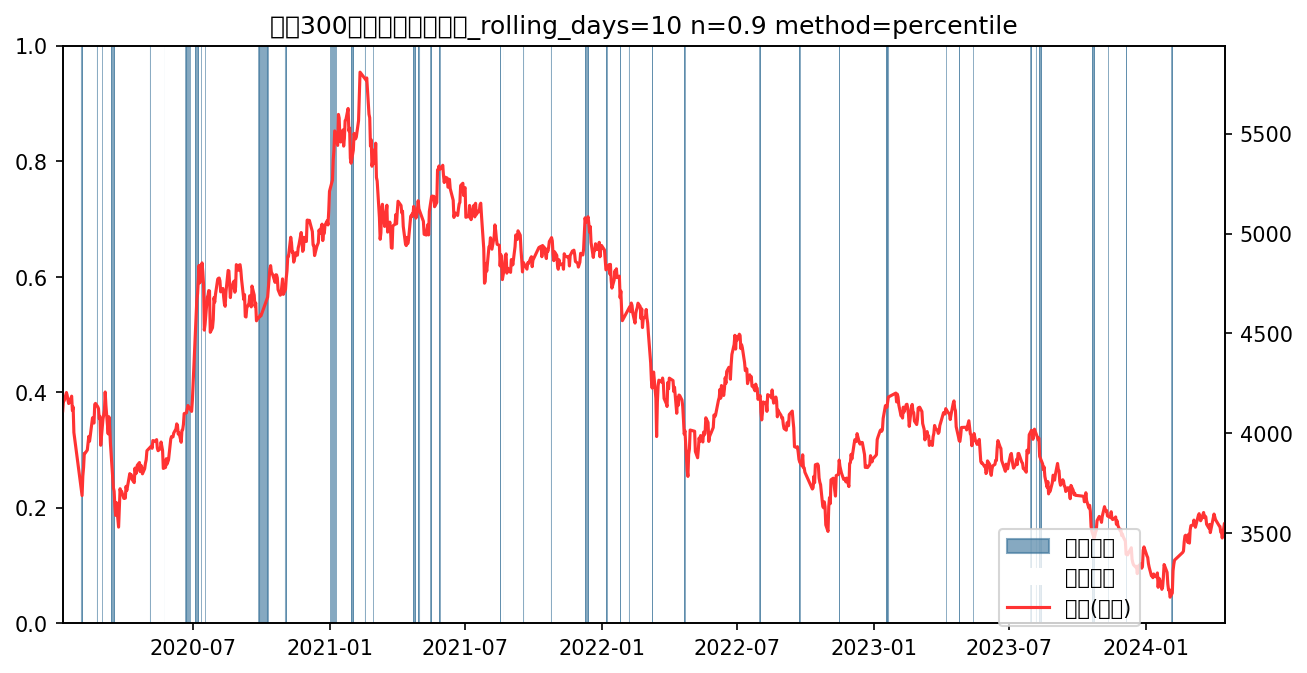

findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the following families were found: Hiragino Sans GB
findfont: Generic family 'sans-serif' not found because none of the foll

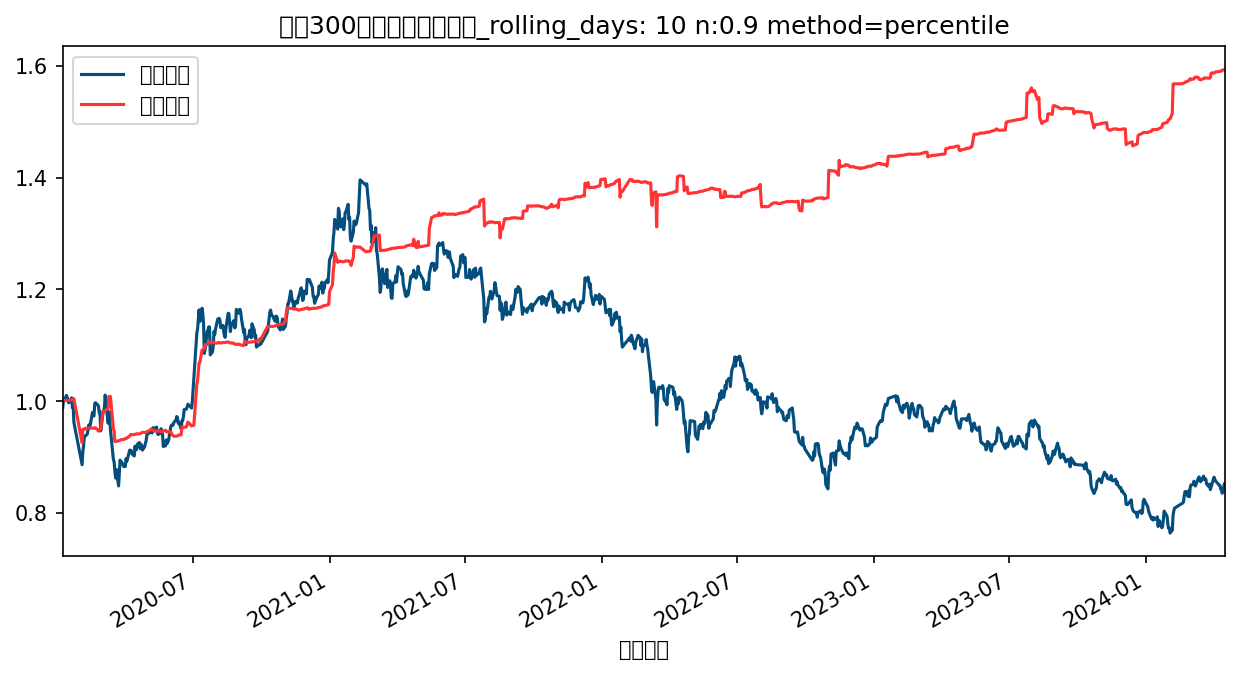

,R,bond_index_pct,index_close,VIX,VIX_vol,GVIX,rolling_percentile,position,index_return,bond_return,timing_return,index_nav,timing_nav
交易日期,,,,,,,,,,,,,
2020-01-08,0.031337,0.000473,4112.3172,19.318091,25.893541,19.225949,0.8,-1.0,-0.011516,0.000473,0.000473,0.988484,1.000473
2020-01-09,0.031184,0.000309,4164.3697,18.227695,23.917267,18.140290,0.6,-1.0,0.012658,0.000309,0.000309,1.000996,1.000783
2020-01-10,0.030819,0.000793,4163.1849,17.381474,24.814399,17.330401,0.4,-1.0,-0.000285,0.000793,0.000793,1.000711,1.001577
2020-01-13,0.030840,0.000409,4203.9883,17.198959,20.362985,17.173523,0.3,-1.0,0.009801,0.000409,0.000409,1.010519,1.001986
2020-01-14,0.030994,-0.000306,4189.8862,16.658449,23.519932,16.649993,0.2,-1.0,-0.003354,-0.000306,-0.000306,1.007129,1.001680
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-10,0.022972,-0.000086,3504.7086,15.392251,21.293104,15.419794,0.1,-1.0,-0.008145,-0.000086,-0.000086,0.842432,1.590517
2024-04-11,0.022928,0.000190,3504.2447,14.946173,21.181256,14.977736,0.1,-1.0,-0.000132,0.000190,0.000190,0.842320,1.590819
2024-04-12,0.022837,0.000948,3475.8389,14.673962,21.419712,14.675424,0.1,-1.0,-0.008106,0.000948,0.000948,0.835493,1.592326


In [28]:
rolling_days = 10
rolling_percentile = 0.9

df_VIX_result = percentile_method_position(df_VIX_result, 'VIX', rolling_days, rolling_percentile)
timing_strategy(df_VIX_result, rolling_days, rolling_percentile, method='percentile')

In [29]:
''' 计算策略效果 '''
period = 252

def calculate_strategy_effect(df, period):
    ''' 计算年化收益 '''
    initial_nav = df['timing_nav'].iloc[0]
    final_nav = df['timing_nav'].iloc[-1]
    annual_return = (final_nav / initial_nav) ** (period / (len(df) - 1)) - 1 
    
    ''' 计算年化波动率 '''    
    annual_std = df['timing_return'].std() * np.sqrt(period)
    
    ''' 计算夏普 '''
    sharpe = annual_return / annual_std
    
    ''' 计算最大回撤 '''
    df['pre_peak'] = df['timing_nav'].cummax()
    df['maximum_drawdown'] = df['timing_nav'] / df['pre_peak'] - 1
    maximum_drawdown = df['maximum_drawdown'].min()
    return annual_return, annual_std, sharpe, maximum_drawdown

strategy_effect = calculate_strategy_effect(df_VIX_result, period)

annual_return = strategy_effect[0]
annual_std = strategy_effect[1]
sharpe = strategy_effect[2]
maximum_drawdown = strategy_effect[3]

print(f'\n------------------- strategy effect ---------------------\n'
      f'annual return: {annual_return * 100:.2f}%\n'
      f'annual std: {annual_std * 100:.2f}%\n'
      f'sharpe ratio: {sharpe:.4f}\n'
      f'maximum drawdown: {maximum_drawdown * 100:.2f}%\n'
      )


------------------- strategy effect ---------------------
annual return: 12.03%
annual std: 9.44%
sharpe ratio: 1.2739
maximum drawdown: -8.02%
